This notebook collects all the code presented in my blog post <a href="">Simulated Annealing and vacation planning (solving the TSP with multiple constraints)</a>. This code also generates the figures shown in the post.

In [1]:
# Import libraries for printing maps
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

# Print map of cities function
def print_map(lon,lat,s=[]):
    fig, ax = plt.subplots(figsize=(10,7))
    m = Basemap(resolution='l', # c, l, i, h, f or None
            projection='merc',
            lat_0=10.8, lon_0=12.37,
            llcrnrlon=6.59, llcrnrlat= 36.42, urcrnrlon=18.96, urcrnrlat=47.22)
    m.drawmapboundary(fill_color='#46bcec')
    m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
    m.drawcoastlines()
    for i in range(len(lon)):
        x, y = m(lon[i],lat[i])
        m.plot(x, y, 'o', markersize=8, color='red', alpha=0.8)
    x, y = m(lon[s],lat[s])
    m.plot(x,y,lw=2.0,alpha=1.0)
    plt.show()
    
    return

In [2]:
# Import libraries
import pandas as pd
import numpy as np
# Set random seed
np.random.seed(0)

# Read data, create x and y coordinate variables and 
# N which is the total number of cities
df = pd.read_csv("datasets/italy_cities.csv")
N = len(df)
x = np.array(df['Lon'])
y = np.array(df['Lat'])
print(df.head())

       Name    Lat    Lon
0   Bologna  44.30  11.21
1  Cagliari  39.15   9.03
2   Catania  37.30  15.05
3  Florence  43.47  11.15
4   Messina  38.11  15.33


In [3]:
# Now create the lookup-table for the distances
# Extract cities names
cities = df['Name'].values
# Preallocate look-up table
dtable = [[0.0 for c in cities] for c in cities]
# Calculate distances
for i, ci in enumerate(cities):
    for j, cj in enumerate(cities):
        delta_lon = df.loc[df['Name'] == ci, 'Lon'].values - df.loc[df['Name'] == cj, 'Lon'].values
        delta_lat = df.loc[df['Name'] == ci, 'Lat'].values - df.loc[df['Name'] == cj, 'Lat'].values
        dtable[i][j] = float(np.sqrt(delta_lon**2 + delta_lat**2))

# Now we normalize all the distances from 0 to 1
dmax = np.max(dtable)
dmin = np.min(dtable)
dtable = [[(x - dmin) / (dmax - dmin) for x in r] for r in dtable]

In [4]:
df = pd.read_csv('datasets/italy_prices.csv')
df['price'] = df['price'].apply(lambda x: (x - df['price'].min())/(df['price'].max() - df['price'].min()))
print(df.head(5))

     cityA     cityB     price
0  Bologna  Cagliari  0.298165
1  Bologna   Catania  0.736239
2  Bologna  Florence  0.073394
3  Bologna   Messina  0.844037
4  Bologna    Milano  0.795872


In [5]:
# Create mapping city-id to setup prices table
mapping = {}
imapping = {}
for idcity,cname in enumerate(cities):
    # mapping: name -> id
    mapping[cname] = idcity
    # inverse mapping: id -> name
    imapping[idcity] = cname
# Build price look-up table
ptable = [[0.0 for c in cities] for c in cities]
for i,row in df.iterrows():
    ptable[mapping[row['cityA']]][mapping[row['cityB']]] = row['price']
    ptable[mapping[row['cityB']]][mapping[row['cityA']]] = row['price']

In [6]:
# Set seed for reproducibility of the results
np.random.seed(0)
# Initialize state (path)
s = np.arange(N)
np.random.shuffle(s)
# Append first city id to end of path (we need a closed path!)
s = np.append(s,s[0])
print(s)
print([imapping[idc] for idc in s])

[ 1  6  8  9 14  4  2 13 10  7 11  3  0  5 12  1]
['Cagliari', 'Napoli', 'Rome', 'Torino', 'Bari', 'Messina', 'Catania', 'Genova', 'Venice', 'Palermo', 'Trento', 'Florence', 'Bologna', 'Milano', 'Trieste', 'Cagliari']


In [7]:
# Cost function
def get_cost(dtable, ptable, alpha, s, N):
    L = 0.0
    P = 0.0
    for i in range(N):
        # Calculate length and price components
        L += dtable[s[i]][s[i+1]]
        P += ptable[s[i]][s[i+1]]
    # Return cost 
    return alpha * L + (1. - alpha) * P

In [8]:
# Get total cost using a balanced combination of price/length (alpha = 0.5)
alpha = 0.5
total_cost = get_cost(dtable, ptable, alpha, s, N)
print('Total (balanced) cost: %6.4f' %total_cost)
# Get total price using alpha = 0.0
alpha = 0.0
total_cost = get_cost(dtable, ptable, alpha, s, N)
print('Total price: %6.4f' %total_cost)
# Get total distance using alpha = 1.0
alpha = 1.0
total_cost = get_cost(dtable, ptable, alpha, s, N)
print('Total distance: %6.4f' %total_cost)

Total (balanced) cost: 7.3254
Total price: 7.8486
Total distance: 6.8022


In [9]:
# Inputs are price and distance look-up tables, the mixing parameter alpha,
# the configuration s (a list containing the cities ids in the order of the path),
# the total number of cities N, the initial annealing temperature and the maximum 
# number of iterations to be performed
def anneal(dtable, ptable, alpha, s, N, T0=1.0, iter_max=10000, verbose=True):
    # Counters to keep track of accepted/rejected moves and path length
    acc = 0        
    rej = 0
    J = get_cost(dtable, ptable, alpha, s, N)
    if verbose:
        print('Initial guess length: %7.4f' % J)
    # Array to keep track of the cost as we iterate
    Jarr = [J]
    # Set initial temperature
    T = T0
    if verbose:
        print('Initial temperature: %7.4f' % T0)
    # Initiate iterative steps
    for i in range(1,iter_max+1):
        # Annealing (reduce temperature, cool down with steps)
        # Here we decrease the temperature every 100 steps
        if i % 100 == 0:
            T = 0.999 * T
        # Generate two random indices and switch them (switch cities)
        # We keep first and last cities fixed (note they are also the same
        # since the path must be closed)
        j,k = np.random.randint(low=1,high=N,size=2)
        s_new = np.copy(s)
        s_new[j] = s[k]
        s_new[k] = s[j]
        # Calculate length of new state (path)
        Jnew = get_cost(dtable, ptable, alpha, s_new, N)
        deltaJ = Jnew - J
        # Accept the move if new path is shorter than previous one
        if deltaJ <= 0.0:
            s = np.copy(s_new)
            J = Jnew
            acc += 1
        # If new path is larger than previous, accept the move with probability
        # proportional to the Boltzmann factor
        elif deltaJ > 0.0:
            u = np.random.uniform()
            if u < np.exp( - deltaJ / T):
                s = np.copy(s_new)
                J = Jnew
                acc += 1
            else:
                rej += 1
        # Every 100 steps record the cost
        if i % 100 == 0:
            Jarr.append(J)
    
    # Return final configuration s, list keeping track of the cost,
    # final temperature T and number of accepted and rejected moves
    return s, Jarr, T, acc, rej

Initial guess length:  6.8022
Initial temperature:  1.0000
Accepted moves: 141842
Rejected moves: 358158
Final temperature:  0.0067
Final length after optimization:  3.0766


/home/mirko/.conda/envs/eq_env/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/mirko/.conda/envs/eq_env/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/mirko/.conda/envs/eq_env/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/mirko/.conda/envs/eq_env/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


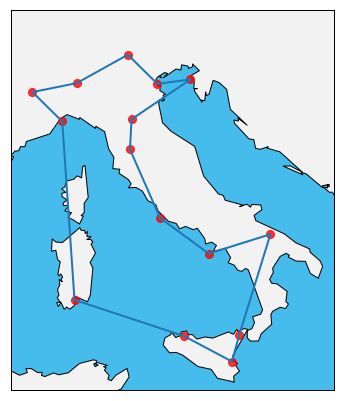

In [10]:
# Set seed for reproducibility of the results
np.random.seed(721)
# Set parameters
alpha = 1.0       # Mixing parameter 
T0 = 1.0          # Initial temperature
iter_max = 500000 # Number of iterations
# Simulate annealing
s, Jarr, T, accepted, rejected = anneal(dtable, ptable, alpha, s, N, T0, iter_max, verbose=True)
print('Accepted moves: %d' % accepted)
print('Rejected moves: %d' % rejected)
print('Final temperature: %7.4f' % T)
print('Final length after optimization: %7.4f' % Jarr[-1])
print_map(x,y,s)

Initial guess length:  6.8022
Initial temperature:  1.0000
Initial guess length:  6.5011
Initial temperature:  1.0000
Initial guess length:  8.2641
Initial temperature:  1.0000
Initial guess length:  6.9196
Initial temperature:  1.0000
Initial guess length:  7.5798
Initial temperature:  1.0000
Initial guess length:  8.0634
Initial temperature:  1.0000
Initial guess length:  7.6532
Initial temperature:  1.0000
Initial guess length:  7.5382
Initial temperature:  1.0000
Initial guess length:  6.9579
Initial temperature:  1.0000
Initial guess length:  7.9928
Initial temperature:  1.0000
Length of the optimal path:  3.0757


/home/mirko/.conda/envs/eq_env/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/mirko/.conda/envs/eq_env/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/mirko/.conda/envs/eq_env/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/mirko/.conda/envs/eq_env/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


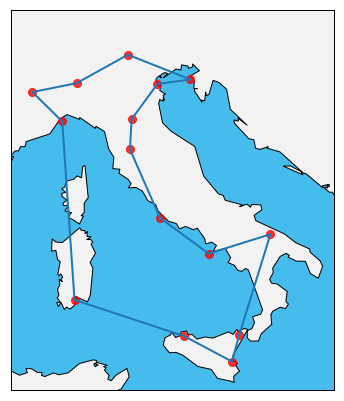

In [ ]:
# Set seed for reproducibility of the results
np.random.seed(0)
# Here we perform simulated annealing 10 times and select as optimal solution
# the one which gives the lowest path
s_best = None
Jbest = None
for i in range(10):
    s = np.arange(N)
    np.random.shuffle(s)
    s = np.append(s,s[0])
    if s_best is None:
        s_best = np.copy(s)
    if Jbest is None:
        Jbest = get_cost(dtable, ptable, alpha, s, N)
    # Set parameters
    alpha = 1.0       # Mixing parameter 
    T0 = 1.0          # Initial temperature
    iter_max = 500000 # Number of iterations
    # Optimize with annealing
    s, Jarr, T, accepted, rejected = anneal(dtable, ptable, alpha, s, N, T0, iter_max, verbose=True)
    # Check if this solution is better than the previous one
    if Jarr[-1] < Jbest:
        Jbest = Jarr[-1]
        s_best = np.copy(s)
print('Length of the optimal path: %7.4f' % Jbest)
# Print map of best path
print_map(x,y,s_best)

In [ ]:
# Set seed for reproducibility of the results
np.random.seed(0)
# Here we perform simulated annealing 10 times and select as optimal solution
# the one which gives the lowest path
s_best = None
Jbest = None
for i in range(10):
    s = np.arange(N)
    np.random.shuffle(s)
    s = np.append(s,s[0])
    if s_best is None:
        s_best = np.copy(s)
    if Jbest is None:
        Jbest = get_cost(dtable, ptable, alpha, s, N)
    # Set parameters
    alpha = 0.5       # Mixing parameter 
    T0 = 1.0          # Initial temperature
    iter_max = 500000 # Number of iterations
    # Optimize with annealing
    s, Jarr, T, accepted, rejected = anneal(dtable, ptable, alpha, s, N, T0, iter_max, verbose=True)
    # Check if this solution is better than the previous one
    if Jarr[-1] < Jbest:
        Jbest = Jarr[-1]
        s_best = np.copy(s)
print('Length of the optimal path: %7.4f' % Jbest)
print_map(x,y,s_best)

Initial guess length:  7.3254
Initial temperature:  1.0000


The following scripts relates to the section "Scaling up", we calculate the best path for world cities. For this calculation I use the `C++` implementation of the annealing code.

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

# Print world map
def print_map_world(df, s):
    fig, ax = plt.subplots(figsize=(20,14))

    earth = Basemap(resolution='l', projection='mill')
    earth.drawcoastlines(color='0.50', linewidth=0.25)
    earth.fillcontinents(color='0.95')

    for i,r in df.iterrows():
        x, y = earth(r['Lon'],r['Lat'])
        earth.plot(x, y, 'o', markersize=4, markerfacecolor='red', markeredgecolor='black', alpha=0.8)

    x, y = earth(np.array(df['Lon'])[s],np.array(df['Lat'])[s])
    earth.plot(x,y,lw=0.5,color='blue',alpha=1.0)
    plt.show()

# Import libraries
import pandas as pd
import numpy as np
# Set random seed
np.random.seed(0)

# Read data, create x and y coordinate variables and 
# N which is the total number of cities
df = pd.read_csv('datasets/world_cities.csv').drop_duplicates(subset='Name')
N = len(df)
x = np.array(df['Lon'])
y = np.array(df['Lat'])
print(df.head())


# Now create the lookup-table for the distances
# Extract cities names
cities = df['Name'].values
# Preallocate look-up table
dtable = [[0.0 for c in cities] for c in cities]

# Calculate distance look-up tables
# Here I saved previously the table on file so that I just need to load it
fin = open('datasets/world_cities_dtable.csv','r')
for line in fin:
    line = line.rstrip('\n').split(',')
    dtable[int(line[0])][int(line[1])] = float(line[2])
fin.close()

# Uncomment if you want to recalculate the table and save it to file
#fout = open('world_cities_dtable.csv','w')
#for i, ci in enumerate(cities):
#    for j, cj in enumerate(cities):
#        delta_lon = df.loc[df['Name'] == ci, 'Lon'].values - df.loc[df['Name'] == cj, 'Lon'].values
#        delta_lat = df.loc[df['Name'] == ci, 'Lat'].values - df.loc[df['Name'] == cj, 'Lat'].values
#        dtable[i][j] = float(np.sqrt(delta_lon**2 + delta_lat**2))
#        fout.write(str(i) + ',' + str(j) + ',' + str(dtable[i][j]) + '\n')
#fout.close()

# Now we normalize all the distances from 0 to 1
dmax = np.max(dtable)
dmin = np.min(dtable)
dtable = [[(x - dmin) / (dmax - dmin) for x in r] for r in dtable]

# Create mapping city-id to setup prices table
mapping = {}
imapping = {}
for idcity,cname in enumerate(cities):
    # mapping: name -> id
    mapping[cname] = idcity
    # inverse mapping: id -> name
    imapping[idcity] = cname

In [ ]:
# Set seed for reproducibility of the results
np.random.seed(0)
# Initialize state (path)
s = np.arange(N)
np.random.shuffle(s)
# Append first city id to end of path (we need a closed path!)
s = np.append(s,s[0])
print(s)
print([imapping[idc] for idc in s])

In [ ]:
# Here I use the C++ library for the annealing schedule and perform one annealing
# schedule on the world cities
import sys
import time
sys.path.append('cpp/')
import lib_anneal as lann

t = time.time()
T0 = 1.0
iter_max = 1000000
alpha = 1.0
ptable = [[]]
s, Jarr, T, accepted, rejected = lann.anneal(dtable, ptable, alpha, s, N, T0, iter_max, 0, True)
print("Execution time: ", time.time() - t)
print('Accepted moves: %d' % accepted)
print('Rejected moves: %d' % rejected)
print('Final temperature: %7.4f' % T)
print('Final length after optimization: %7.4f' % Jarr[-1])
print_map_world(df, s)